In [10]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# !unzip -o data/imgs-20240502T035937Z-001.zip >/dev/null 2>&1;


In [3]:
# !unzip -o data/imgs-20240502T035937Z-002.zip >/dev/null 2>&1;


In [4]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [5]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Available GPUs: 
[]



In [6]:
df = pd.read_csv('data/undersampled_top_10.csv')
X = []
y = []
df_efficient = df.set_index('catalogNumber')
df_efficient.head(5)

,Unnamed: 0,gbifID,references,basisOfRecord,sex,lifeStage,behavior,eventTime,month,continent,countryCode,verbatimElevation,decimalLatitude,decimalLongitude,mediaType,genus,species
catalogNumber,,,,,,,,,,,,,,,,,
XC361568,117,2243757996,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,flight call,6:07:00 PM,3.0,EUROPE,DE,260 m,48.9870,9.0108,Sound;StillImage;StillImage,Loxia,Loxia curvirostra
XC361676,122,2243757192,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,5:30:00 PM,3.0,EUROPE,GR,40 m,36.8217,21.9273,StillImage;StillImage;Sound,Sylvia,Sylvia atricapilla
XC361991,137,3909408313,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,call,10:00:00 AM,3.0,EUROPE,NL,0 m,52.3568,4.5675,StillImage;StillImage;Sound,Fringilla,Fringilla coelebs
XC362620,162,2243759376,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, sweeoo call",2:27:00 PM,4.0,EUROPE,DE,300 m,49.0102,8.8949,Sound;StillImage;StillImage,Phylloscopus,Phylloscopus collybita
XC363724,205,2243761271,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,NaN,NaN,"call, imitation",7:30:00 AM,4.0,EUROPE,PL,160 m,53.1490,20.2591,Sound;StillImage;StillImage,Parus,Parus major


In [7]:
#Construct arrays
X = []
y = []
if (not (os.path.exists('data/specs.npy') and os.path.exists('data/labels.npy'))):
    for index, fname in enumerate(os.listdir('imgs/')):
        try:
            if index % 5000 == 0:
                print(f'{index} done')
            file = os.path.join('imgs', fname)
            X.append(np.array(Image.open(file)))
            basename = os.path.basename(file)
            category = basename.split("_")[0]
            species = df_efficient[df_efficient.index == category]['species'].values
            assert(len(species) == 1)
            y.append(species[0])
        except Exception as e:
            print(str(e))
            print(fname)
    images = np.array(X)
    string_labels = np.array(y)
    np.save('data/specs.npy', images)
    np.save('data/labels.npy', string_labels)
else: 
    images = np.load('data/specs.npy')
    string_labels = np.load('data/labels.npy')

We iterate through all the images in the folder and convert it into a numpy array. We then get the species for the catalogNumber by searching it up in the dataframe and add it to the classification numpy array. We then save the numpy arrays.  

['[UNK]', 'Turdus merula', 'Turdus philomelos', 'Sylvia atricapilla', 'Erithacus rubecula', 'Fringilla coelebs', 'Strix aluco', 'Parus major', 'Troglodytes troglodytes', 'Phylloscopus collybita', 'Loxia curvirostra']


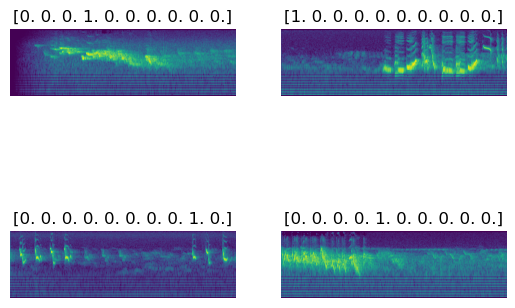

In [16]:

lookup = tf.keras.layers.StringLookup()


# Fit the lookup layer to your labels
lookup.adapt(string_labels)

# Convert the string labels to integer indices
integer_encoded_labels = lookup(string_labels).numpy() - 1
labels = to_categorical(integer_encoded_labels, num_classes = len(np.unique(string_labels)))
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state=42)

print(lookup.get_vocabulary())
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

fig, axs = plt.subplots(2,2)
for ax, img, label in [(a, *b) for a, b in zip(axs.ravel(), train_dataset.take(4))]:
    ax.imshow(img)
    ax.axis(False)
    ax.set_title(f'{label}')

Above, we are visualizing the audio of (from left to right, top to bottom) Erithacus rubecula, Turdus merula, Phylloscopus collybita, and Fringilla coelebs. 

We do a train test split of 80/20, and then a train val split of 80/20, stratified by the species label. We then convert these to tensorflow datasets and save them into files so we can pass them around different machines.

In [15]:
mapping = {val: idx for idx, val in enumerate(lookup.get_vocabulary(include_special_tokens=False))}
import pickle 

with open('tf_data/species_encoding.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [17]:
train_dataset.save('tf_data/train_data')
test_dataset.save('tf_data/test_data')
val_dataset.save('tf_data/validation_data')